**TASK 1**
The goal of this project is “build a data mining model such that, given
the input of the brewing data, it guess the origin of this cup of coffee.
In task 1, you need to complete the following pre-processing tasks:

*   Task 1.1: Visualize samples (5 pt) Loading data and use python (package
matplotlib) to plot the data.
*   Task 1.2: By visualizing such data, answer which features you think is the
best to form a data mining problem? Write down your answer in your submitted
report.
*   Task 1.3: Convert the text label “Sprout” and “Rwanda” to numbers so
that we could implement our classification model. To do so, you can form a
new label array such that replacing all “Sprout” to 0 and “Rwanda” to 1. This
array will be useful for Task 2

---



In [11]:
import numpy as np

data = np.load('coffee_combined_data.npz')

dataset = data['dataset']
labels = data['labels']

print(dataset.shape)
print(labels.shape)
print(labels[:10])



(20, 1995)
(20,)
['Sprout' 'Sprout' 'Sprout' 'Sprout' 'Sprout' 'Sprout' 'Sprout' 'Sprout'
 'Sprout' 'Sprout']


**Task 1.1**
Visualize samples (5 pt) Loading data and use python (package
matplotlib) to plot the data

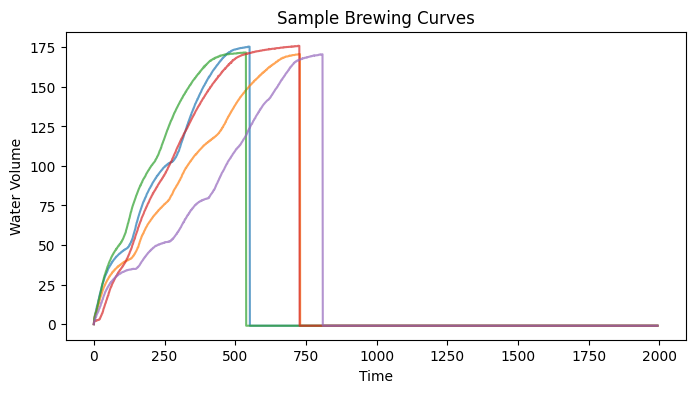

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

for i in range(5):
    plt.plot(dataset[i], alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Water Volume")
plt.title("Sample Brewing Curves")
plt.show()


**Task 1.2**
By visualizing such data, answer which features you think is the
best to form a data mining problem? Write down your answer in your submitted
report.

Ans: By visualizing the brewing curves, we observe that different coffee origins exhibit different pouring patterns, total water volume, and slope changes over time. Therefore, features such as final water volume, average pouring rate, and brewing duration are informative for distinguishing coffee origins.


---



**Task 1.3**
Convert the text label “Sprout” and “Rwanda” to numbers so
that we could implement our classification model. To do so, you can form a
new label array such that replacing all “Sprout” to 0 and “Rwanda” to 1. This
array will be useful for Task 2

In [13]:
labels_numeric = np.zeros(len(labels))

labels_numeric[labels == 'Rwanda'] = 1
labels_numeric[labels == 'Sprout'] = 0

print(labels_numeric[:10])
print(np.unique(labels_numeric))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1.]


**TASK 2**
After you extracted the feature, next step, we will conduct a human feature vs.
machine feature challenge. We have four steps in this part:


*   Task 2.1: Train a linear model using the labeled data by gradient descent. Apply the model to the test data. Your code should return the class label.

*   Task 2.2: As shown in the class, the performance of the model can be
changed by stacking different equations. Design a model and train it with the
labeled data by gradient descent. Apply the model to the test data. Your code
should return the class label. Then report your accuracy in the testing data.

*   Task 2.3: Taking cross validation into account, train both models using
60% of labeled data and use the other 40% of labeled data to adjust which
learning rate you should use and which epoch you should stop. Write down
your observation in your submitted report.

*   Task 2.4: I will provide 4 unlabeled coffee data in the later stage of the
project. Please write down your model output in your report.
*   bonus 2pt: team who get all 4 samples correct will recieve extra bonus









In [14]:
import numpy as np

# ---------- Load labeled training data ----------
train_npz = np.load("coffee_combined_data.npz", allow_pickle=True)
dataset = train_npz["dataset"]        # (20, 1995)
labels_text = train_npz["labels"]     # (20,)  strings: "Sprout" / "Rwanda"

# ---------- Convert labels: Sprout -> 0, Rwanda -> 1 ----------
y = np.zeros(len(labels_text), dtype=np.int64)
y[labels_text == "Rwanda"] = 1
y[labels_text == "Sprout"] = 0

print("dataset:", dataset.shape)
print("labels:", labels_text.shape, "unique:", np.unique(labels_text))
print("y unique:", np.unique(y))

# ---------- Load 4 unlabeled test samples ----------
test_npz = np.load("test_data.npz", allow_pickle=True)
test_keys = test_npz.files  # ['test_data1','test_data2','test_data3','test_data4']
X_unlabeled_raw = np.stack([test_npz[k] for k in test_keys], axis=0)  # (4, 1995)
print("unlabeled test:", X_unlabeled_raw.shape, "keys:", test_keys)


# ---------- Helpers ----------
def sigmoid(z):
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def bce_loss(y_true, y_prob, eps=1e-12):
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true*np.log(y_prob) + (1-y_true)*np.log(1-y_prob))

def acc(y_true, y_pred):
    return np.mean(y_true == y_pred)

def label_to_text(yhat01):
    return np.where(yhat01 == 1, "Rwanda", "Sprout")


dataset: (20, 1995)
labels: (20,) unique: ['Rwanda' 'Sprout']
y unique: [0 1]
unlabeled test: (4, 1995) keys: ['test_data1', 'test_data2', 'test_data3', 'test_data4']


In [15]:
def extract_features(raw_curves):
    """
    raw_curves: (N, T) with T=1995
    returns X: (N, 5)
    """
    N, T = raw_curves.shape
    X = np.zeros((N, 5), dtype=np.float64)

    for i in range(N):
        ycurve = raw_curves[i].astype(np.float64)

        final_volume = np.max(ycurve)
        t_end = int(np.argmax(ycurve == final_volume))  # first time reaching max
        duration = t_end + 1

        avg_rate = final_volume / max(duration, 1)
        area = np.sum(ycurve[:duration])               # integral-ish up to end
        max_slope = np.max(np.diff(ycurve[:duration])) if duration > 1 else 0.0

        X[i] = [final_volume, duration, avg_rate, area, max_slope]

    return X

X = extract_features(dataset)
print("X:", X.shape)
print("feature sample (row 0):", X[0])


X: (20, 5)
feature sample (row 0): [1.75400000e+02 5.46000000e+02 3.21245421e-01 5.72105800e+04
 2.09000000e+00]


In [23]:
def standardize_fit(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma[sigma == 0] = 1.0
    return mu, sigma

def standardize_apply(X, mu, sigma):
    return (X - mu) / sigma

mu, sigma = standardize_fit(X)
Xz = standardize_apply(X, mu, sigma)


**TASK 2.1**

In [24]:
def train_logreg_gd(X, y, lr=0.1, epochs=2000):
    """
    Logistic regression: p = sigmoid(Xw + b)
    X: (N, d)
    y: (N,)
    """
    N, d = X.shape
    w = np.zeros(d, dtype=np.float64)
    b = 0.0

    for ep in range(epochs):
        z = X @ w + b
        p = sigmoid(z)

        # gradients
        grad_w = (X.T @ (p - y)) / N
        grad_b = np.mean(p - y)

        # update
        w -= lr * grad_w
        b -= lr * grad_b

    return w, b

def predict_logreg(X, w, b, thr=0.5):
    p = sigmoid(X @ w + b)
    yhat = (p >= thr).astype(np.int64)
    return yhat, p

# --- Train on ALL labeled data (task says train a model) ---
w1, b1 = train_logreg_gd(Xz, y, lr=0.1, epochs=3000)
yhat_train_1, p_train_1 = predict_logreg(Xz, w1, b1)
print("Task 2.1 train accuracy (on labeled set):", acc(y, yhat_train_1))


Task 2.1 train accuracy (on labeled set): 0.75


**Task 2.2**

In [18]:
def stack_features_poly(X):
    """
    X: (N, d)
    returns Phi: (N, D) with [X, X^2, X^3, pairwise products]
    """
    N, d = X.shape
    X2 = X**2
    X3 = X**3

    # pairwise products (upper triangle i<j)
    pairs = []
    for i in range(d):
        for j in range(i+1, d):
            pairs.append((X[:, i] * X[:, j]).reshape(-1, 1))
    P = np.hstack(pairs) if pairs else np.zeros((N, 0))

    Phi = np.hstack([X, X2, X3, P])
    return Phi

# split labeled data into train/test for reporting accuracy
rng = np.random.default_rng(7)
idx = np.arange(len(y))
rng.shuffle(idx)

split = int(0.7 * len(y))  # 70/30 just for Task 2.2 report
tr, te = idx[:split], idx[split:]

Xtr, Xte = X[tr], X[idx[split:]]
ytr, yte = y[tr], y[idx[split:]]

# standardize based on train split
mu2, sig2 = standardize_fit(Xtr)
Xtrz = standardize_apply(Xtr, mu2, sig2)
Xtez = standardize_apply(Xte, mu2, sig2)

# stacked model
Phi_tr = stack_features_poly(Xtrz)
Phi_te = stack_features_poly(Xtez)

w2, b2 = train_logreg_gd(Phi_tr, ytr, lr=0.05, epochs=5000)
yhat_te_2, _ = predict_logreg(Phi_te, w2, b2)

print("Task 2.2 test accuracy (30% holdout):", acc(yte, yhat_te_2))
print("yte:", yte)
print("pred:", yhat_te_2)


Task 2.2 test accuracy (30% holdout): 0.3333333333333333
yte: [0 1 1 0 0 1]
pred: [0 0 0 0 1 0]


**Task 2.3**

In [19]:
def train_logreg_gd_with_history(Xtr, ytr, Xva, yva, lr=0.1, max_epochs=8000):
    N, d = Xtr.shape
    w = np.zeros(d, dtype=np.float64)
    b = 0.0

    best = {"val_loss": np.inf, "epoch": 0, "w": None, "b": None}

    for ep in range(1, max_epochs+1):
        # forward
        ptr = sigmoid(Xtr @ w + b)
        pva = sigmoid(Xva @ w + b)

        # compute losses
        tr_loss = bce_loss(ytr, ptr)
        va_loss = bce_loss(yva, pva)

        # track best epoch (early stopping criterion)
        if va_loss < best["val_loss"]:
            best["val_loss"] = va_loss
            best["epoch"] = ep
            best["w"] = w.copy()
            best["b"] = b

        # gradients on train
        grad_w = (Xtr.T @ (ptr - ytr)) / N
        grad_b = np.mean(ptr - ytr)

        # update
        w -= lr * grad_w
        b -= lr * grad_b

    return best

# 60/40 split
rng = np.random.default_rng(42)
idx = np.arange(len(y))
rng.shuffle(idx)

split = int(0.6 * len(y))
tr, va = idx[:split], idx[split:]

Xtr, Xva = X[tr], X[va]
ytr, yva = y[tr], y[va]

# standardize using train only
mu3, sig3 = standardize_fit(Xtr)
Xtrz = standardize_apply(Xtr, mu3, sig3)
Xvaz = standardize_apply(Xva, mu3, sig3)

lrs = [0.001, 0.005, 0.01, 0.05, 0.1]

# ---- Model 1 (linear) ----
best1_overall = {"val_loss": np.inf}
for lr in lrs:
    best1 = train_logreg_gd_with_history(Xtrz, ytr, Xvaz, yva, lr=lr, max_epochs=8000)
    if best1["val_loss"] < best1_overall["val_loss"]:
        best1_overall = {"lr": lr, **best1}

print("Task 2.3 (Linear) best lr:", best1_overall["lr"], "best epoch:", best1_overall["epoch"], "val_loss:", best1_overall["val_loss"])

# ---- Model 2 (stacked) ----
Phi_tr = stack_features_poly(Xtrz)
Phi_va = stack_features_poly(Xvaz)

best2_overall = {"val_loss": np.inf}
for lr in lrs:
    best2 = train_logreg_gd_with_history(Phi_tr, ytr, Phi_va, yva, lr=lr, max_epochs=8000)
    if best2["val_loss"] < best2_overall["val_loss"]:
        best2_overall = {"lr": lr, **best2}

print("Task 2.3 (Stacked) best lr:", best2_overall["lr"], "best epoch:", best2_overall["epoch"], "val_loss:", best2_overall["val_loss"])

# report validation accuracies at selected params
yhat_va_1, _ = predict_logreg(Xvaz, best1_overall["w"], best1_overall["b"])
yhat_va_2, _ = predict_logreg(Phi_va, best2_overall["w"], best2_overall["b"])

print("Linear val acc:", acc(yva, yhat_va_1))
print("Stacked val acc:", acc(yva, yhat_va_2))


Task 2.3 (Linear) best lr: 0.1 best epoch: 21 val_loss: 0.685734921784745
Task 2.3 (Stacked) best lr: 0.1 best epoch: 5 val_loss: 0.6755706825540919
Linear val acc: 0.625
Stacked val acc: 0.25


**Task 2.4**

In [21]:
# choose best model: stacked (you can switch to linear if it wins)
use_stacked = True

# extract + standardize unlabeled using mu3/sig3 from 60/40 train split
Xu = extract_features(X_unlabeled_raw)
Xuz = standardize_apply(Xu, mu3, sig3)

if use_stacked:
    Phi_u = stack_features_poly(Xuz)
    yhat_u, p_u = predict_logreg(Phi_u, best2_overall["w"], best2_overall["b"])
else:
    yhat_u, p_u = predict_logreg(Xuz, best1_overall["w"], best1_overall["b"])

print("Task 2.4 outputs for 4 unlabeled samples:")
for k, pred01, prob in zip(test_keys, yhat_u, p_u):
    print(k, "->", int(pred01), label_to_text(np.array([pred01]))[0], "prob(Rwanda)=", float(prob))


Task 2.4 outputs for 4 unlabeled samples:
test_data1 -> 0 Sprout prob(Rwanda)= 0.45183947375629613
test_data2 -> 1 Rwanda prob(Rwanda)= 0.5010723766328053
test_data3 -> 0 Sprout prob(Rwanda)= 0.4330455995791714
test_data4 -> 0 Sprout prob(Rwanda)= 0.4821018993069391


**BONUS POINTS SECTION**

In [22]:
print("BONUS predictions (copy into report):")
for k, pred01 in zip(test_keys, yhat_u):
    print(k, ":", label_to_text(np.array([pred01]))[0])


BONUS predictions (copy into report):
test_data1 : Sprout
test_data2 : Rwanda
test_data3 : Sprout
test_data4 : Sprout


# ===============================
# Export human-crafted features
# ===============================



In [25]:
import pandas as pd

# Recompute features to be explicit
X_features = extract_features(dataset)

feature_names = [
    "final_volume",
    "duration",
    "avg_rate",
    "area",
    "max_slope"
]

df_features = pd.DataFrame(X_features, columns=feature_names)

# add label (text, not numeric)
df_features["label"] = labels_text

# save to csv
csv_path = "crafted_features.csv"
df_features.to_csv(csv_path, index=False)

print("Saved:", csv_path)
df_features.head()


Saved: crafted_features.csv


,final_volume,duration,avg_rate,area,max_slope,label
0,175.4,546.0,0.321245,57210.58,2.09,Sprout
1,170.7,725.0,0.235448,73684.18,2.40,Sprout
2,171.7,530.0,0.323962,60251.77,2.00,Sprout
3,176.0,724.0,0.243094,84569.27,1.30,Sprout
4,170.6,803.0,0.212453,72256.52,1.20,Sprout
